<a href="https://colab.research.google.com/github/MiguelyGallego/deep_learning/blob/main/practica_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy
import pandas
import imageio.v3 as io

from tqdm import tqdm
from typing import Optional, Union

import tensorflow as tf
import numpy as np
import seaborn as sns

from numpy.ma.core import shape
from tensorflow.keras import optimizers, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.applications import VGG16

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
!wget -O "airbnb-listings.csv" "https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B"

--2023-07-16 10:44:32--  https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&refine.country=Spain&q=Madrid&timezone=Europe/London&use_labels_for_header=true&csv_separator=%3B
Resolving public.opendatasoft.com (public.opendatasoft.com)... 34.249.199.226, 34.248.20.69
Connecting to public.opendatasoft.com (public.opendatasoft.com)|34.249.199.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/csv]
Saving to: ‘airbnb-listings.csv’

airbnb-listings.csv     [    <=>             ]  54.31M  3.01MB/s    in 18s     

2023-07-16 10:44:53 (2.98 MB/s) - ‘airbnb-listings.csv’ saved [56950929]



In [ ]:
data = pandas.read_csv("airbnb-listings.csv", sep = ';')
data = data.dropna(subset=['Price'])
data = data.dropna(subset=['Picture Url'])

In [ ]:
def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = numpy.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=numpy.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:  # Unavailable url / conversion error
        pass
  return images[downloaded_idxs], downloaded_idxs

In [ ]:
images, idxs = download_images(data['Picture Url'], max_imgs=2000)
images = images.astype("float32") / 255.
images.shape

100%|██████████| 2000/2000 [24:42<00:00,  1.35it/s]


(2000, 224, 224, 3)

In [ ]:
filtered_data = data.iloc[idxs]
filtered_data.describe()

,ID,Scrape ID,Host ID,Host Response Rate,Host Acceptance Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,...,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Jurisdiction Names,Calculated host listings count,Reviews per Month
count,2.000000e+03,2.000000e+03,2.000000e+03,1754.000000,0.0,1999.000000,1999.000000,2000.000000,2000.000000,2000.00000,...,1564.000000,1562.000000,1563.000000,1560.000000,1563.000000,1560.000000,1559.000000,0.0,2000.000000,1577.000000
mean,1.016339e+07,2.017040e+13,3.694594e+07,94.803877,NaN,13.437219,13.437219,40.418855,-3.371064,3.27500,...,91.760870,9.402049,9.344210,9.629487,9.652591,9.528205,9.237973,NaN,10.072500,1.889328
std,5.585993e+06,1.572003e+07,3.404518e+07,15.226462,NaN,35.396551,35.396551,0.196143,1.393870,2.10656,...,8.334136,0.902525,0.988673,0.773123,0.707721,0.788288,0.896689,NaN,24.356085,1.910336
min,6.242300e+04,2.017032e+13,5.352600e+04,0.000000,NaN,0.000000,0.000000,39.394149,-3.785982,1.00000,...,26.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.020000
25%,5.265944e+06,2.017041e+13,7.567063e+06,99.000000,NaN,1.000000,1.000000,40.409105,-3.707231,2.00000,...,88.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,1.000000,0.450000
50%,1.124437e+07,2.017041e+13,2.716999e+07,100.000000,NaN,2.000000,2.000000,40.417456,-3.700623,3.00000,...,93.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,2.000000,1.210000
75%,1.522657e+07,2.017041e+13,5.564096e+07,100.000000,NaN,6.000000,6.000000,40.427717,-3.688402,4.00000,...,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,5.000000,2.830000
max,1.810434e+07,2.017041e+13,1.245462e+08,100.000000,NaN,207.000000,207.000000,41.416297,3.455065,16.00000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,145.000000,13.600000


In [ ]:
numpy.save('images.npy', images)
filtered_data.to_csv('filtered_data.csv', sep=';', index=False)

In [ ]:
!cp images.npy /content/drive/MyDrive/KeepCoding/Deep_Learning/Practica/images_final.npy
!cp filtered_data.csv /content/drive/MyDrive/KeepCoding/Deep_Learning/Practica/filtered_data.csv

!ls -lah images* filtered*  # Comprobación

-rw-r--r-- 1 root root 7.9M Jul 16 11:10 filtered_data.csv
-rw-r--r-- 1 root root 1.2G Jul 16 11:10 images.npy


In [ ]:
# Comprobamos a abrirlos de nuevo
saved_data = pandas.read_csv("/content/drive/MyDrive/KeepCoding/Deep_Learning/Practica/filtered_data.csv", sep=';')
saved_imgs = numpy.load("/content/drive/MyDrive/KeepCoding/Deep_Learning/Practica/images_final.npy")
saved_data.shape, saved_imgs.shape

((2000, 89), (2000, 224, 224, 3))

In [ ]:
# Sleccionar columnas de interés

interest_data = saved_data[['Property Type', 'Room Type', 'Cancellation Policy','Accommodates', 'Bathrooms',
                            'Bedrooms', 'Beds','Guests Included', 'Extra People',
                            'Minimum Nights', 'Maximum Nights', 'Number of Reviews',
                            'Host Total Listings Count', 'Price']]

interest_data.shape, saved_imgs.shape

((2000, 14), (2000, 224, 224, 3))

In [ ]:
# Borrar las filas NaN

# Identificar las filas con valores NaN
rows_with_nan = interest_data.isna().any(axis=1)

# Obtener los índices de las filas con valores NaN
nan_indices = interest_data[rows_with_nan].index

# Eliminar las filas de saved_data
interest_data = interest_data.drop(nan_indices)

# Eliminar las filas de saved_img
saved_imgs_fil = np.delete(saved_imgs, nan_indices, axis=0)

# Comprobamos que ambos sets de datos tengan el mismo tamaño
interest_data.shape, saved_imgs_fil.shape

((1982, 14), (1982, 224, 224, 3))

In [ ]:
# Codificación de variables categóricas

# Lista de nombres de las variables categóricas a codificar
categorical_variables = ['Property Type', 'Room Type', 'Cancellation Policy']

# Crear una instancia de LabelEncoder para cada variable categórica
label_encoders = {}
for variable in categorical_variables:
    label_encoders[variable] = LabelEncoder()

# Ajustar y transformar los valores de cada columna categórica
for variable in categorical_variables:
    encoded_values = label_encoders[variable].fit_transform(interest_data[variable])
    interest_data[variable] = encoded_values

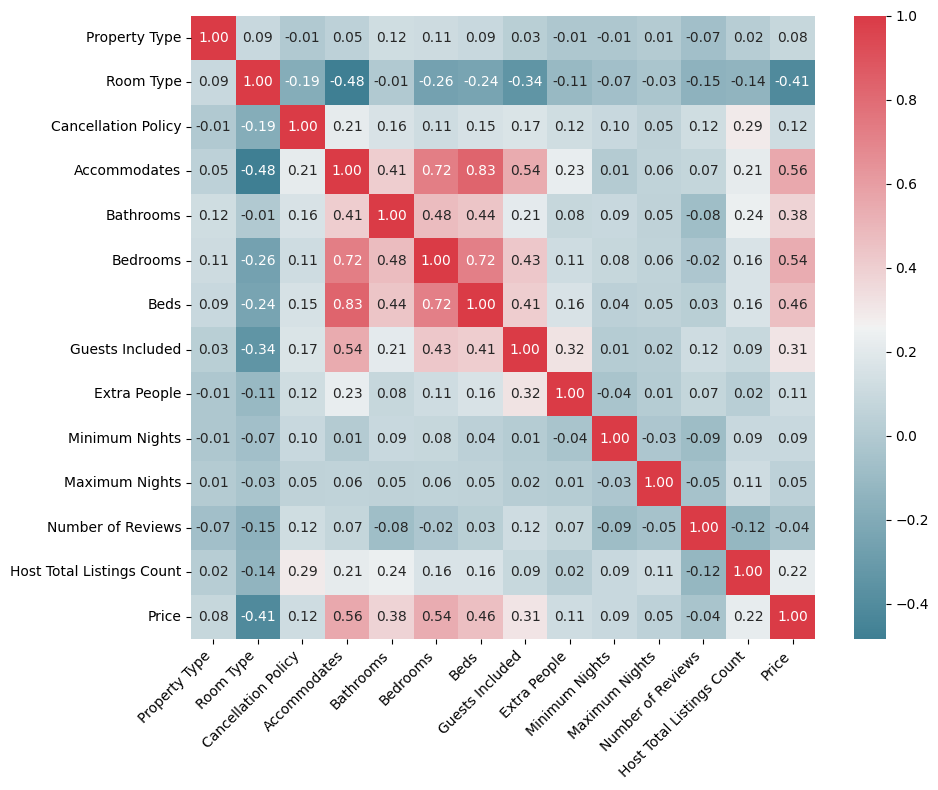

In [ ]:
# Matréz de correlación para seleccionar columnas

# Calcular la matriz de correlación
corr = np.corrcoef(interest_data, rowvar=False)

# Generar una máscara para la diagonal y la mitad inferior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Aplicar la máscara a la matriz de correlación
corr_masked = np.ma.masked_array(corr, mask)

# Crear un mapa de colores personalizado
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Crear un gráfico de mapa de calor
ax = sns.heatmap(corr_masked, cmap=cmap, annot=True, fmt=".2f", cbar=True, square=True)

# Obtener los nombres de las características
feature_names = ['Property Type', 'Room Type', 'Cancellation Policy', 'Accommodates', 'Bathrooms', 'Bedrooms',
                 'Beds','Guests Included', 'Extra People','Minimum Nights', 'Maximum Nights',
                 'Number of Reviews','Host Total Listings Count', 'Price']

# Configurar las etiquetas de los ejes x e y
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_yticklabels(feature_names, rotation=0)

# Ajustar los márgenes del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [ ]:
# Selecionamos las columnas más relacionadas con el precio

selected_data = interest_data[[ "Accommodates", "Bathrooms", "Bedrooms", "Beds", "Guests Included", 'Price']]

selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1982 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Accommodates     1982 non-null   int64  
 1   Bathrooms        1982 non-null   float64
 2   Bedrooms         1982 non-null   float64
 3   Beds             1982 non-null   float64
 4   Guests Included  1982 non-null   int64  
 5   Price            1982 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 108.4 KB


In [ ]:
#@title MODELOS PARA TABULARES


In [ ]:
# Identificamos la variable objetivo y dovidimos entre train y test
X = selected_data.drop('Price', axis=1)
y = selected_data['Price']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Verifica las dimensiones de los conjuntos de datos divididos
print("Dimensiones de los conjuntos de datos:")
print("Conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Conjunto de validación:", X_val.shape, y_val.shape)
print("Conjunto de prueba:", X_test.shape, y_test.shape)

Dimensiones de los conjuntos de datos:
Conjunto de entrenamiento: (1268, 5) (1268,)
Conjunto de validación: (317, 5) (317,)
Conjunto de prueba: (397, 5) (397,)


In [ ]:
X.describe()

,Property Type,Room Type,Cancellation Policy,Accommodates,Bathrooms,Bedrooms,Beds,Guests Included,Extra People,Minimum Nights,Maximum Nights,Number of Reviews,Host Total Listings Count
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.00000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,1.426075,0.399866,1.099126,3.272513,1.271505,1.33871,2.047043,1.588710,7.492272,2.979839,850.766465,22.718750,12.736559
std,3.254563,0.519263,0.848084,2.058146,0.671540,0.88926,1.609156,1.165986,12.457900,5.168905,529.721029,37.776413,33.950767
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,365.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,3.000000,1.000000,1.00000,2.000000,1.000000,0.000000,2.000000,1125.000000,7.000000,2.000000
75%,0.000000,1.000000,2.000000,4.000000,1.000000,2.00000,2.000000,2.000000,14.000000,3.000000,1125.000000,27.000000,6.000000
max,14.000000,2.000000,4.000000,16.000000,8.000000,10.00000,16.000000,16.000000,276.000000,99.000000,11111.000000,343.000000,207.000000


In [ ]:
# Normalizamos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:


lr=0.005
n_epochs=25
batch_size=32

# Definir el modelo de la red neuronal
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer=Adam(lr), metrics=['mse'])

# Entrenar el modelo
H = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=batch_size, verbose=1)

model.save('/content/drive/MyDrive/KeepCoding/Deep_Learning/Practica/tab_model.h5')

Epoch 1/25
40/40 [==============================] - 2s 10ms/step - loss: 7385.4604 - mse: 7385.4604 - val_loss: 7364.3989 - val_mse: 7364.3989
Epoch 2/25
40/40 [==============================] - 0s 5ms/step - loss: 2959.7822 - mse: 2959.7822 - val_loss: 4317.0547 - val_mse: 4317.0547
Epoch 3/25
40/40 [==============================] - 0s 5ms/step - loss: 2475.8965 - mse: 2475.8965 - val_loss: 4291.9082 - val_mse: 4291.9082
Epoch 4/25
40/40 [==============================] - 0s 5ms/step - loss: 2415.0881 - mse: 2415.0881 - val_loss: 4315.8545 - val_mse: 4315.8545
Epoch 5/25
40/40 [==============================] - 0s 6ms/step - loss: 2384.8733 - mse: 2384.8733 - val_loss: 4336.6987 - val_mse: 4336.6987
Epoch 6/25
40/40 [==============================] - 0s 5ms/step - loss: 2370.1467 - mse: 2370.1467 - val_loss: 4359.3062 - val_mse: 4359.3062
Epoch 7/25
40/40 [==============================] - 0s 5ms/step - loss: 2358.5142 - mse: 2358.5142 - val_loss: 4289.8003 - val_mse: 4289.8003
Epoch

In [ ]:
# Cargaar el modelo

tab_model = load_model('/content/drive/MyDrive/KeepCoding/Deep_Learning/Practica/tab_model.h5')

tab_model.compile(loss='mean_squared_error',
              metrics=[MeanAbsoluteError(), MeanSquaredError()])

In [ ]:

batch_size=32

# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions_tab = tab_model.predict(X_test, batch_size=batch_size)

# Calcular el MSE
mse = mean_squared_error(y_test, predictions_tab)
print(mse)

# Calcular el MAE
mae = mean_absolute_error(y_test, predictions_tab)
print(mae)

# Calcular el RMSE
rmse = np.sqrt(mse)
print(rmse)

# Calcular R^2
r2 = r2_score(y_test, predictions_tab)
print(r2)

# Obtener la pérdida y el MSE en cada época
train_loss = H.history['loss']
val_loss = H.history['val_loss']
train_mse = H.history['mse']
val_mse = H.history['val_mse']

# Graficar la pérdida y el MSE en función de las épocas
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_mse, 'b-', label='Train MSE')
plt.plot(epochs, val_mse, 'r-', label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

[INFO]: Evaluando red neuronal...
13/13 [==============================] - 3s 3ms/step
690117.9188870102
747.4480034278082
830.7333620885887
-247.59134561013244


NameError: ignored

In [ ]:
# Calculamos la media de precios en el test, y calculamos el mean squared error y mean absolute error si todas las predicciones valieran esa media.
# Con esto pretendemos tener algun tipo de umbral límite para saber si la red está aprendiendo

mean_price = y_test.mean()
print("Media de precios en el conjunto de prueba:", mean_price)

predicted_prices = np.full_like(y_test, mean_price)

mse = mean_squared_error(y_test, predicted_prices)
mae = mean_absolute_error(y_test, predicted_prices)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Media de precios en el conjunto de prueba: 65.91275167785236
Mean Squared Error: 3403.2239313544437
Mean Absolute Error: 35.02909778838791


In [ ]:
#@title MODELOS PARA IMÁGENES


In [ ]:
# División de los conjuntos de datos
Xi_train_val, Xi_test, yi_train_val, yi_test = train_test_split(saved_imgs_fil, selected_data['Price'], test_size=0.2, random_state=42)
Xi_train, Xi_val, yi_train, yi_val = train_test_split(Xi_train_val, yi_train_val, test_size=0.2, random_state=42)

# Verifica las dimensiones de los conjuntos de datos divididos
print("Dimensiones de los conjuntos de datos:")
print("Conjunto de entrenamiento:", Xi_train.shape, yi_train.shape)
print("Conjunto de validación:", Xi_val.shape, yi_val.shape)
print("Conjunto de prueba:", Xi_test.shape, yi_test.shape)

Dimensiones de los conjuntos de datos:
Conjunto de entrenamiento: (1268, 224, 224, 3) (1268,)
Conjunto de validación: (317, 224, 224, 3) (317,)
Conjunto de prueba: (397, 224, 224, 3) (397,)


In [ ]:
# Calculamos la media de precios en el test, y calculamos el mean squared error y mean absolute error si todas las predicciones valieran esa media.
# Con esto pretendemos tener algun tipo de umbral límite para saber si la red está aprendiendo

mean_price = yi_test.mean()
print("Media de precios en el conjunto de prueba:", mean_price)

predicted_prices = np.full_like(yi_test, mean_price)

mse = mean_squared_error(yi_test, predicted_prices)
mae = mean_absolute_error(yi_test, predicted_prices)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Media de precios en el conjunto de prueba: 67.78643216080403
Mean Squared Error: 3212.2433335016794
Mean Absolute Error: 36.90723719098003


In [ ]:
# MODELO CONVOLUCIONAL

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)
n_epochs=10
batch_size=32

# Definir la arquitectura del modelo
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(Xi_train.shape[1], Xi_train.shape[2], Xi_train.shape[3])))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer=Adam(lr_schedule), metrics=[MeanAbsoluteError(), MeanSquaredError()])

# Entrenar el modelo
history = model.fit(Xi_train, yi_train, validation_data=(Xi_val, yi_val), epochs=n_epochs, batch_size=batch_size)


Epoch 1/10
60/60 [==============================] - 17s 79ms/step - loss: 4696.1152 - mean_absolute_error: 41.9977 - mean_squared_error: 4696.1152 - val_loss: 6301.9937 - val_mean_absolute_error: 40.4901 - val_mean_squared_error: 6301.9937
Epoch 2/10
60/60 [==============================] - 3s 45ms/step - loss: 4068.7634 - mean_absolute_error: 38.0857 - mean_squared_error: 4068.7634 - val_loss: 6351.8247 - val_mean_absolute_error: 39.2177 - val_mean_squared_error: 6351.8247
Epoch 3/10
60/60 [==============================] - 3s 46ms/step - loss: 3979.4639 - mean_absolute_error: 38.4065 - mean_squared_error: 3979.4639 - val_loss: 6677.2139 - val_mean_absolute_error: 40.3171 - val_mean_squared_error: 6677.2139
Epoch 4/10
60/60 [==============================] - 3s 45ms/step - loss: 4027.8232 - mean_absolute_error: 37.5493 - mean_squared_error: 4027.8232 - val_loss: 6134.6826 - val_mean_absolute_error: 39.1482 - val_mean_squared_error: 6134.6826
Epoch 5/10
60/60 [=========================

In [ ]:
# Evaluar el modelo en el conjunto de prueba
mse, mae, _ = model.evaluate(Xi_test, yi_test)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Hacer predicciones
predictions = model.predict(Xi_test)

# Graficar la evolución del entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, mae, 'b-', label='Training MAE')
plt.plot(epochs, val_mae, 'r-', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

19/19 [==============================] - 1s 42ms/step - loss: 3265.9055 - mean_absolute_error: 37.2651 - mean_squared_error: 3265.9055


In [ ]:
# construimos el modelo base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(Xi_train.shape[1], Xi_train.shape[2], Xi_train.shape[3]))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# FEATURE EXTRACTION

# congelamos todas las capas de nuestro base_model para que no se entrenen
# queremos que nuestro feature extractor siga igual que antes => transfer learning
for layer in base_model.layers:
  layer.trainable = False
  print('Capa ' + layer.name + ' congelada.')


# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(64, activation='relu', name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(1, activation='relu', name='predictions')(x)
model = Model(base_model.input, x)

# compilamos el modelo
model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error', metrics=[MeanAbsoluteError(), MeanSquaredError()])

# vemos la estructura del modelo
model.summary()

Capa input_1 congelada.
Capa block1_conv1 congelada.
Capa block1_conv2 congelada.
Capa block1_pool congelada.
Capa block2_conv1 congelada.
Capa block2_conv2 congelada.
Capa block2_pool congelada.
Capa block3_conv1 congelada.
Capa block3_conv2 congelada.
Capa block3_conv3 congelada.
Capa block3_pool congelada.
Capa block4_conv1 congelada.
Capa block4_conv2 congelada.
Capa block4_conv3 congelada.
Capa block4_pool congelada.
Capa block5_conv1 congelada.
Capa block5_conv2 congelada.
Capa block5_conv3 congelada.
Capa block5_pool congelada.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64

In [ ]:
# comenzamos con el entrenamiento
epochs = 15
batch_size = 128

# como entrenariamos normalmente
history = model.fit(Xi_train, yi_train,
          batch_size=batch_size,
          validation_data=(Xi_test, yi_test),
          epochs=epochs)


Epoch 1/15
10/10 [==============================] - 53s 3s/step - loss: 4272.0640 - mean_absolute_error: 44.0532 - mean_squared_error: 4272.0640 - val_loss: 3098.0972 - val_mean_absolute_error: 39.7325 - val_mean_squared_error: 3098.0972
Epoch 2/15
10/10 [==============================] - 8s 775ms/step - loss: 3095.9807 - mean_absolute_error: 34.3479 - mean_squared_error: 3095.9807 - val_loss: 3101.4861 - val_mean_absolute_error: 40.8114 - val_mean_squared_error: 3101.4861
Epoch 3/15
10/10 [==============================] - 7s 772ms/step - loss: 2936.1145 - mean_absolute_error: 33.8334 - mean_squared_error: 2936.1145 - val_loss: 2984.5771 - val_mean_absolute_error: 38.6641 - val_mean_squared_error: 2984.5771
Epoch 4/15
10/10 [==============================] - 7s 682ms/step - loss: 2511.5269 - mean_absolute_error: 30.8098 - mean_squared_error: 2511.5269 - val_loss: 2867.4294 - val_mean_absolute_error: 34.7781 - val_mean_squared_error: 2867.4294
Epoch 5/15
10/10 [========================

In [ ]:
# Evaluar el modelo en el conjunto de prueba
mse, mae, _ = model.evaluate(Xi_test, yi_test)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Obtener las métricas del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
train_mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

# Graficar las métricas de pérdida
plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Graficar las métricas de MAE
plt.plot(range(1, epochs+1), train_mae, label='Train MAE')
plt.plot(range(1, epochs+1), val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

# Graficar las métricas de MSE
plt.plot(range(1, epochs+1), train_mse, label='Train MSE')
plt.plot(range(1, epochs+1), val_mse, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Validation MSE')
plt.legend()
plt.show()

In [ ]:
## FINE-TUNING

# Hiperparámetros
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

# permitimos que, además de la etapa de clasificación, se entrenen también el
# último bloque convolucional
for layer in base_model.layers:
  layer.trainable = False
  if layer.name == "block5_conv3":
    layer.trainable = True

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(64, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='relu', name='predictions')(x)
model = Model(base_model.input, x)

# compilamos el modelo
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='mean_squared_error', metrics=(MeanAbsoluteError(), MeanSquaredError()))

# vemos la nueva estructura del modelo
model.summary()

# Guardar el modelo
model.save('/content/drive/MyDrive/KeepCoding/Deep_Learning/Practica/img_model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# comenzamos con el entrenamiento
epochs = 15
batch_size = 256

# como entrenariamos normalmente
history = model.fit(Xi_train, yi_train,
          batch_size=batch_size,
          validation_data=(Xi_test, yi_test),
          epochs=epochs)

# Guardar el modelo
model.save('/content/drive/MyDrive/KeepCoding/Deep_Learning/Practica/img_model.h5')

Epoch 1/15
5/5 [==============================] - 95s 13s/step - loss: 5508.6460 - mean_absolute_error: 51.2878 - mean_squared_error: 5508.6460 - val_loss: 4288.0420 - val_mean_absolute_error: 38.7415 - val_mean_squared_error: 4288.0420
Epoch 2/15
5/5 [==============================] - 8s 2s/step - loss: 4033.6951 - mean_absolute_error: 39.5545 - mean_squared_error: 4033.6951 - val_loss: 3658.5579 - val_mean_absolute_error: 47.2502 - val_mean_squared_error: 3658.5579
Epoch 3/15
5/5 [==============================] - 7s 2s/step - loss: 3608.1438 - mean_absolute_error: 40.4210 - mean_squared_error: 3608.1438 - val_loss: 3269.6621 - val_mean_absolute_error: 32.9574 - val_mean_squared_error: 3269.6621
Epoch 4/15
5/5 [==============================] - 8s 2s/step - loss: 3451.8511 - mean_absolute_error: 34.5178 - mean_squared_error: 3451.8511 - val_loss: 3067.2896 - val_mean_absolute_error: 39.0623 - val_mean_squared_error: 3067.2896
Epoch 5/15
5/5 [==============================] - 8s 2s/st

In [ ]:
# Cargaar el modelo

img_model = load_model('/content/drive/MyDrive/KeepCoding/Deep_Learning/Practica/img_model.h5')

img_model.compile(loss='mean_squared_error',
              metrics=[MeanAbsoluteError(), MeanSquaredError()])

In [ ]:
# comprobamos el accuracy y el loss en el test set
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

13/13 [==============================] - 2s 123ms/step - loss: 3833.7390 - mean_absolute_error: 35.6594 - mean_squared_error: 3833.7390
Test loss: 3833.739013671875
Test accuracy: 35.6594352722168


13/13 [==============================] - 9s 312ms/step - loss: 3103.8315 - mean_absolute_error: 37.5843 - mean_squared_error: 3103.8315
Mean Squared Error: 3103.83154296875
Mean Absolute Error: 37.584346771240234


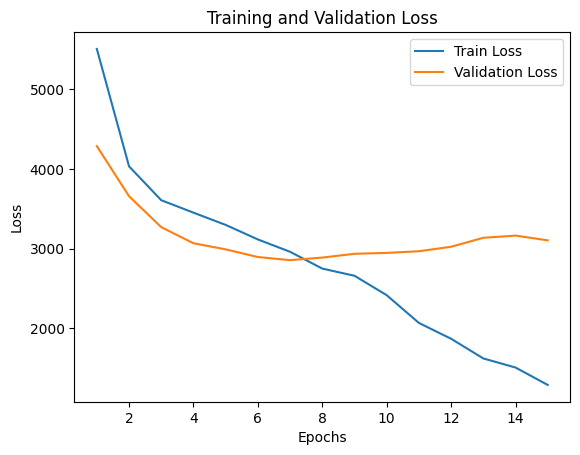

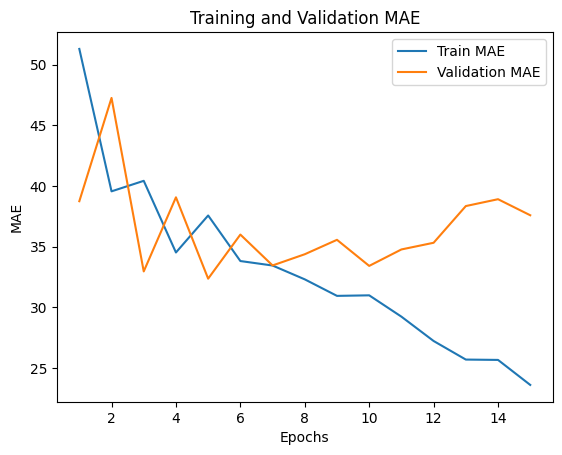

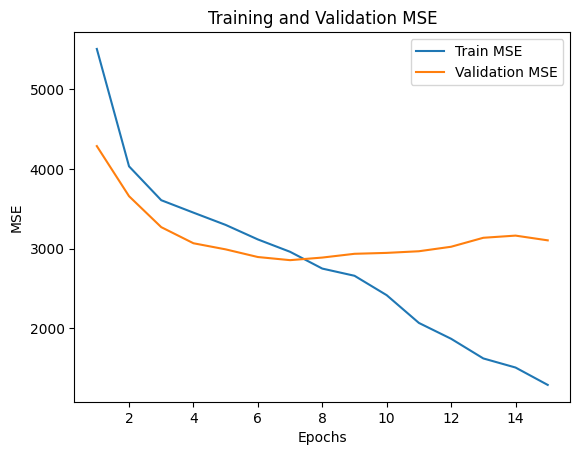

In [ ]:
# Evaluar el modelo en el conjunto de prueba
mse, mae, _ = img_model.evaluate(Xi_test, yi_test)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Obtener las métricas del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
train_mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

# Graficar las métricas de pérdida
plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Graficar las métricas de MAE
plt.plot(range(1, epochs+1), train_mae, label='Train MAE')
plt.plot(range(1, epochs+1), val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

# Graficar las métricas de MSE
plt.plot(range(1, epochs+1), train_mse, label='Train MSE')
plt.plot(range(1, epochs+1), val_mse, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training and Validation MSE')
plt.legend()
plt.show()

In [ ]:
#@title FUSION DE MODELOS


In [ ]:
# LATE-FUSION

# Obtener predicciones del modelo 1D para conjunto de entrenamiento y prueba
predictions_1d_train = tab_model.predict(X_train)
predictions_1d_val = tab_model.predict(X_val)
predictions_1d_test = tab_model.predict(X_test)

# Obtener predicciones del modelo de imágenes para conjunto de entrenamiento y prueba
predictions_images_train = img_model.predict(Xi_train)
predictions_images_val = img_model.predict(Xi_val)
predictions_images_test = img_model.predict(Xi_test)

# Concatenar las predicciones de los dos modelos
X_train_fusion = concatenate([predictions_1d_train, predictions_images_train])
X_val_fusion = concatenate([predictions_1d_val, predictions_images_val])
X_test_fusion = concatenate([predictions_1d_test, predictions_images_test])

X_train_fusion.shape, X_val_fusion.shape, X_test_fusion.shape


13/13 [==============================] - 4s 320ms/step


(TensorShape([1268, 2]), TensorShape([317, 2]), TensorShape([397, 2]))

In [ ]:
# Crear una red neurnal para entrenar a partir de los resultados de ambos modelos

# Agrega las capas necesarias a tu modelo fusionado

lr=0.005
n_epochs=50
batch_size=32

# Definir el modelo de la red neuronal
model_fusion = Sequential()
model_fusion.add(Dense(64, activation='relu', input_dim=X_train_fusion.shape[1]))
model_fusion.add(Dense(64, activation='relu'))
model_fusion.add(Dense(1))

# Compilar el modelo
model_fusion.compile(loss='mean_squared_error', optimizer=Adam(lr), metrics=['mse'])

# Entrenar el modelo
H = model_fusion.fit(X_train_fusion, y_train, validation_data=(X_val_fusion, y_val), epochs=n_epochs, batch_size=batch_size, verbose=1)
predictions_final = model_fusion.predict(X_test_fusion)

Epoch 1/50
40/40 [==============================] - 2s 8ms/step - loss: 5685.4077 - mse: 5685.4077 - val_loss: 6113.6567 - val_mse: 6113.6567
Epoch 2/50
40/40 [==============================] - 0s 4ms/step - loss: 3568.6123 - mse: 3568.6123 - val_loss: 3120.7927 - val_mse: 3120.7927
Epoch 3/50
40/40 [==============================] - 0s 4ms/step - loss: 3268.3914 - mse: 3268.3914 - val_loss: 2853.7451 - val_mse: 2853.7451
Epoch 4/50
40/40 [==============================] - 0s 4ms/step - loss: 3509.3494 - mse: 3509.3494 - val_loss: 3115.2271 - val_mse: 3115.2271
Epoch 5/50
40/40 [==============================] - 0s 4ms/step - loss: 3354.9019 - mse: 3354.9019 - val_loss: 3362.7178 - val_mse: 3362.7178
Epoch 6/50
40/40 [==============================] - 0s 4ms/step - loss: 3418.2402 - mse: 3418.2402 - val_loss: 2975.2654 - val_mse: 2975.2654
Epoch 7/50
40/40 [==============================] - 0s 4ms/step - loss: 3540.4751 - mse: 3540.4751 - val_loss: 3903.7148 - val_mse: 3903.7148
Epoch 

[INFO]: Evaluando red neuronal...
13/13 [==============================] - 0s 2ms/step
690117.9188870102
747.4480034278082
830.7333620885887
-247.59134561013244


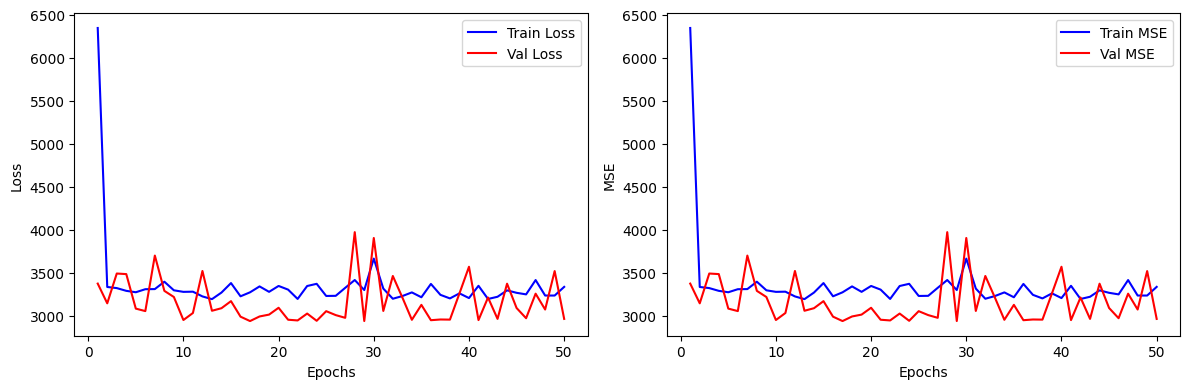

In [ ]:
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions_tab = tab_model.predict(X_test, batch_size=batch_size)

# Calcular el MSE
mse = mean_squared_error(y_test, predictions_tab)
print(mse)

# Calcular el MAE
mae = mean_absolute_error(y_test, predictions_tab)
print(mae)

# Calcular el RMSE
rmse = np.sqrt(mse)
print(rmse)

# Calcular R^2
r2 = r2_score(y_test, predictions_tab)
print(r2)

# Obtener la pérdida y el MSE en cada época
train_loss = H.history['loss']
val_loss = H.history['val_loss']
train_mse = H.history['mse']
val_mse = H.history['val_mse']

# Graficar la pérdida y el MSE en función de las épocas
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_mse, 'b-', label='Train MSE')
plt.plot(epochs, val_mse, 'r-', label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()